In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.integrate import LSODA
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array
from ODE_schemes import stencil_calc

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [48]:
N = len(r_array)

In [113]:
s = 3

i1 = 0
i2 = s
A = np.zeros((N, N))
for i in range(N):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r_array[i1:i2] - r_array[i]
    coeff = stencil_calc(stencil, 1)
    A[i, i1:i2] = coeff
A_log = csr_matrix(A.copy())

In [114]:
μ = 2.34    #(Hayashi 1981)
α_rφ = 8e-3

def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)


def c_s(Ω,  Σ, α_rφ = 8e-3):
    return ((sigma_sb**(-1) * (μ * m_p / k_B)**(-4) * 3/4 * Ω * Σ * α_rφ)**(1/6)).to('m/s')

def temp(r, T_1au= 280 * u.K, p = -1/2):
    return T_1au * (r / (1 * u. au))**p

def soundspeed(r):
    return np.sqrt((k_B * temp(r)) / (μ * m_p))

In [115]:
'''Σ = Σ_initial(r_array * u.au)
inner_1 = Σ * r_array**(2)
inner_2 = α_rφ * c_s(Omega_kep(r_array * u.au), Σ)**2

inner = inner_1 * inner_2
inner_unit = inner.unit

outer = 2 / ((r_array *u.au) * Omega_kep(r_array * u.au)) * (A_log @ inner) * inner_unit
outer_unit = outer.unit
dt = (1 / (r_array * u.au)) * (A_log @ outer) * outer_unit
dt.to('g/(cm2 * kyr)')'''

"Σ = Σ_initial(r_array * u.au)\ninner_1 = Σ * r_array**(2)\ninner_2 = α_rφ * c_s(Omega_kep(r_array * u.au), Σ)**2\n\ninner = inner_1 * inner_2\ninner_unit = inner.unit\n\nouter = 2 / ((r_array *u.au) * Omega_kep(r_array * u.au)) * (A_log @ inner) * inner_unit\nouter_unit = outer.unit\ndt = (1 / (r_array * u.au)) * (A_log @ outer) * outer_unit\ndt.to('g/(cm2 * kyr)')"

In [116]:
def Σ_step(Σ, Δt):
    inner_1 = Σ * (r_array *u.au)**(2)
    inner_2 = α_rφ * soundspeed(r_array * u.au)**2

    inner = inner_1 * inner_2
    inner_unit = inner.unit

    outer = 2 / ((r_array *u.au) * Omega_kep(r_array * u.au)) * (A_log @ inner) * inner_unit
    outer_unit = outer.unit
    dt = (1 / (r_array * u.au)) * (A_log @ outer) * outer_unit
    return Σ + Δt * (dt * u.au**(-2)).to('g/(cm2 * kyr)')

[Text(0.5, 0, 'r [AU]'),
 Text(0, 0.5, 'Σ(r, t) [$g/cm^2$]'),
 Text(0.5, 1.0, 'Surface density\n$M_{disc}=0.11M_{sun}$'),
 None,
 None,
 (0.01, 100000000.0),
 (0.01, 300)]

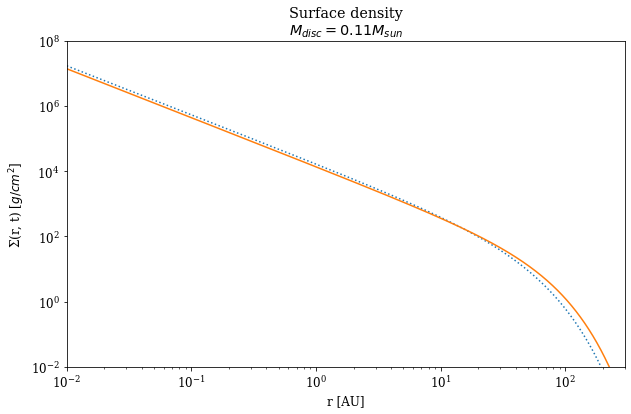

In [117]:
fig, axs = plt.subplots(figsize = (10, 6))

Δt = 1e2 * u.kyr
Σ0 = Σ_initial(r_array * u.au)
res = Σ_step(Σ0, Δt)

axs.loglog(r_array, Σ0, ls = ':',)
axs.loglog(r_array, res)
axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e8), xlim = (0.01, 300))

In [118]:
Δt = 1e2 * u.kyr
Σ0 = Σ_initial(r_array * u.au)
sol = []
Δt_solved = []
t_solved = []

rejected = 0
t = 0 * u.yr
step = 0
ε_rel=2e-2
ε_abs=1e-2
error_area = 1e2

t_final = 1e3 * u.kyr
while t <= t_final:
    res = Σ_step(Σ0, Δt)

    δΣ = np.linalg.norm(res - Σ0) / np.linalg.norm(Σ0)
    ε_tol = ε_rel

    Δt_next =  0.95*((ε_tol)/δΣ) * Δt
    if Δt_next > 1.2 * Δt:
        Δt_next = 1.2 * Δt
    if Δt_next < 0.8 * Δt:
        Δt_next = 0.8 * Δt 
   

    if any(np.isnan(res)) == True:
        break

    if δΣ <= ε_tol:
        step += 1
        t += Δt
        sol.append(res)
        Σ0 = res
        Δt_solved.append(Δt.value)
        t_solved.append(t)
    else:
        rejected += 1  
    Δt = Δt_next 

    if step == 2.5e4:
        break

In [111]:
print(step, rejected)

25000 13032


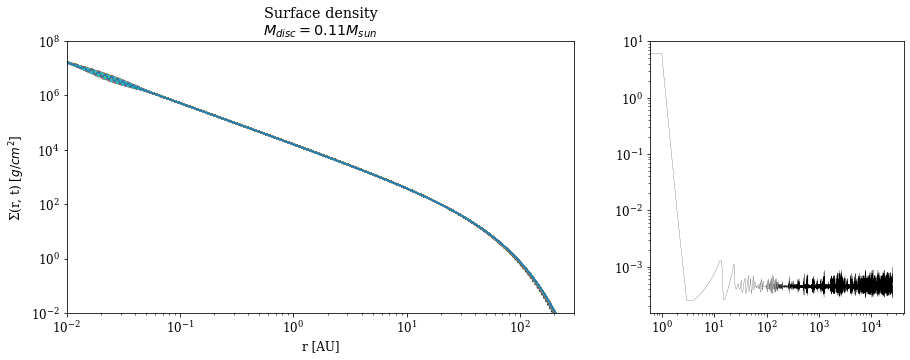

In [112]:
fig, axs = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].loglog(r_array,  Σ_initial(r_array * u.au), c = 'black', ls = ':')
for i in range(step):
    if i % 100 == 0:
        axs[0].loglog(r_array, sol[i])
axs[0].loglog(r_array, sol[-1])

axs[0].set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e8), xlim = (0.01, 300));

axs[1].loglog(Δt_solved, c = 'black', lw = 0.2)